In [15]:
# %pip install pennylane
# %pip install tensorflow
# %pip install pennylane-qiskit
# %pip install matplotlib
# %pip install scikit-learn
# %pip install pandas

In [1]:
import re
import requests
import zipfile
import pickle

import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.saving import register_keras_serializable
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pennylane as qml

Define the URL and file paths

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
zip_file_path = 'smsspamcollection.zip'
extracted_file_path = 'SMSSpamCollection'

Download the dataset

In [3]:
def download_file(url, dest_path):
    response = requests.get(url)
    response.raise_for_status()  # Check for errors
    with open(dest_path, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded {url} to {dest_path}")

In [4]:
download_file(url, zip_file_path)

Downloaded https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip to smsspamcollection.zip


Unzip the downloaded file

In [5]:
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Unzipped {zip_path} to {extract_to}")

In [6]:
unzip_file(zip_file_path, '.')

Unzipped smsspamcollection.zip to .


Load and preprocess data

In [7]:
def load_sms_spam_dataset(filepath):
    df = pd.read_csv(filepath, delimiter='\t', header=None, names=['label', 'text'])
    
    def preprocess_text(text):
        text = text.lower()  # Lowercase text
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text
    
    df['text'] = df['text'].apply(preprocess_text)

    X = df['text'].values
    y = LabelEncoder().fit_transform(df['label'].values)

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X)
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, padding='post', maxlen=20)

    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return X, y, tokenizer

In [8]:
X, y, tokenizer = load_sms_spam_dataset(extracted_file_path)

Split data into training and testing sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define a quantum node with quantum device

In [10]:
def quantum_node(n_qubits, n_layers):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def circuit(inputs):
        # Apply parameterized quantum gates
        for i in range(n_layers):
            qml.RX(inputs[i], wires=i)
            qml.RY(inputs[i], wires=i)
        # Return the expectation value of the first qubit
        return qml.expval(qml.PauliZ(0))
    
    return circuit

Define a Quantum Layer 

In [11]:
@register_keras_serializable()
class QuantumLayer(Layer):
    def __init__(self, n_qubits, n_layers, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.n_qubits = n_qubits
        self.n_layers = n_layers
    
    def call(self, inputs):
        # For testing, simply pass through the inputs
        return tf.keras.backend.sum(inputs, axis=1, keepdims=True)

    def compute_output_shape(self, input_shape):
        # Assuming output shape should match input shape
        return (input_shape[0], 1)
    
    def get_config(self):
        # Include the parameters in the configuration
        config = super(QuantumLayer, self).get_config()
        config.update({
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers
        })
        return config

Build and compile model

In [12]:
def build_model():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128))  # Embedding layer
    model.add(LSTM(units=128))  # LSTM layer
    model.add(Dropout(0.2))  # Dropout layer
    model.add(Dense(16, activation='relu'))  # Dense layer with ReLU activation
    
    # Add the simplified quantum layer
    model.add(QuantumLayer(n_qubits=4, n_layers=4))
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [13]:
model = build_model()

Train the model

In [14]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8344 - loss: 0.6606 - val_accuracy: 0.9731 - val_loss: 0.5635
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9753 - loss: 0.5397 - val_accuracy: 0.9704 - val_loss: 0.5190
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9814 - loss: 0.4947 - val_accuracy: 0.9830 - val_loss: 0.4584
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9873 - loss: 0.4400 - val_accuracy: 0.9839 - val_loss: 0.4191
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9905 - loss: 0.3977 - val_accuracy: 0.9883 - val_loss: 0.3808
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9916 - loss: 0.3600 - val_accuracy: 0.9883 - val_loss: 0.3448
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9933 - loss: 0.3274 - val_accuracy: 0.9883 - val_loss: 0.3237
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9938 - loss: 0.3025 - val_accu

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9838 - loss: 0.1369
Test Accuracy: 0.9848


In [16]:
# Save the model
model.save('quantum_rnn_spam_model.h5.keras')

# Print confirmation message
print("Model saved as quantum_rnn_spam_model.h5.keras")

Model saved as quantum_rnn_spam_model.h5.keras


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9838 - loss: 0.1369
Test Accuracy: 0.9848


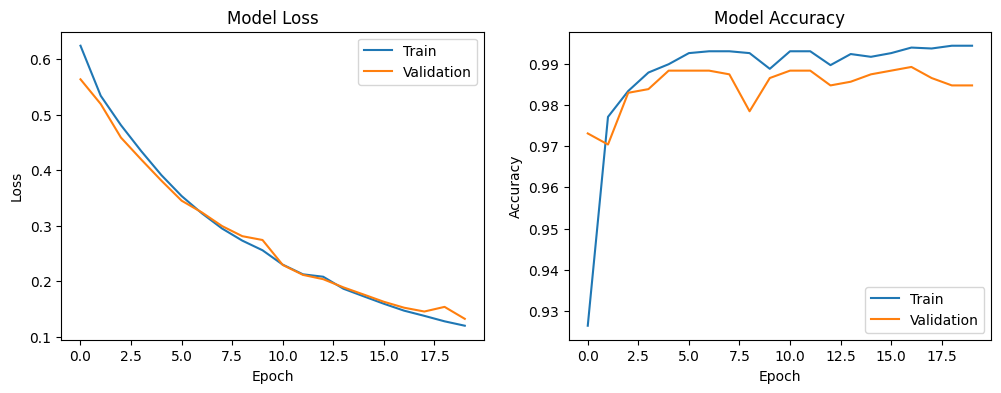

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot training loss and accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

Example new texts - replace with your actual new texts

In [33]:
new_texts = [
    "This is a new text message.",
    "Another example of a text message.",
    "Exclusive offer!",
    "WINNER!!",
    "December only!",
    "XXXMobileMovieClub",
    "🚀❤️"
]

Make predictions

In [34]:
def preprocess_text(text):
    """Preprocess the text to match training data format."""
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

def load_tokenizer(tokenizer_path):
    """Load the tokenizer from a file."""
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    return tokenizer

def predict_texts(model, tokenizer, texts, maxlen=20, threshold=0.5):
    """Predict the class of each text and print the results."""
    # Preprocess and tokenize the texts
    texts_preprocessed = [preprocess_text(text) for text in texts]
    sequences = tokenizer.texts_to_sequences(texts_preprocessed)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    
    # Make predictions
    predictions = model.predict(padded_sequences)
    
    # Print the predictions
    print("Predictions:")
    for i, text in enumerate(texts):
        prediction_prob = predictions[i][0]
        prediction_class = 'spam' if prediction_prob < threshold else 'ham'
        print(f"Text: {text}")
        print(f"Prediction Probability: {prediction_prob:.4f}")
        print(f"Prediction Class: {prediction_class}")

Define file paths

In [35]:
tokenizer_path = 'tokenizer.pickle'
model_path = 'quantum_rnn_spam_model.h5.keras'

Load the tokenizer and model

In [36]:
tokenizer = load_tokenizer(tokenizer_path)
model = load_model(model_path)

Make predictions

In [37]:
predict_texts(model, tokenizer, new_texts, maxlen=20, threshold=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predictions:
Text: This is a new text message.
Prediction Probability: 0.8362
Prediction Class: ham
Text: Another example of a text message.
Prediction Probability: 0.1141
Prediction Class: spam
Text: Exclusive offer!
Prediction Probability: 0.1126
Prediction Class: spam
Text: WINNER!!
Prediction Probability: 0.1126
Prediction Class: spam
Text: December only!
Prediction Probability: 0.1126
Prediction Class: spam
Text: XXXMobileMovieClub
Prediction Probability: 0.1126
Prediction Class: spam
Text: 🚀❤️
Prediction Probability: 0.1126
Prediction Class: spam


In [37]:
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [44]:
import pickle

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [45]:
# Preprocess the new texts
new_texts_preprocessed = [preprocess_text(text) for text in new_texts]

In [46]:
# Convert texts to sequences and pad them
X_new_sequences = tokenizer.texts_to_sequences(new_texts_preprocessed)
X_new = pad_sequences(X_new_sequences, maxlen=20)

In [47]:
# Load the model
model = load_model('quantum_rnn_spam_model.h5.keras')

In [48]:
# Make predictions
predictions = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [49]:
# Define a threshold for classification
threshold = 0.5

In [50]:
# Output predictions
print("Predictions:")
for i, text in enumerate(new_texts):
    prediction_prob = predictions[i][0]
    prediction_class = 'spam' if prediction_prob > threshold else 'ham'
    print(f"Text: {text}")
    print(f"Prediction Probability: {prediction_prob:.4f}")
    print(f"Prediction Class: {prediction_class}")

Predictions:
Text: This is a new text message.
Prediction Probability: 0.0185
Prediction Class: ham
Text: Another example of a text message.
Prediction Probability: 0.0051
Prediction Class: ham
Text: Exclusive offer!
Prediction Probability: 0.0027
Prediction Class: ham
Text:  Call The Mobile Update Co FREE on 08002986906
Prediction Probability: 0.0135
Prediction Class: ham
Text: December only!
Prediction Probability: 0.0030
Prediction Class: ham
Text: Had your mobile 11mths+?
Prediction Probability: 0.0043
Prediction Class: ham
Text:  You are entitled to update to the latest colour camera mobile for Free!
Prediction Probability: 0.4481
Prediction Class: ham


In [19]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'tokenizer.pickle'

In [38]:
# Tokenizer for new texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_texts)
max_sequence_length = 100

In [39]:
# Convert texts to sequences and pad them
X_new_sequences = tokenizer.texts_to_sequences(new_texts)
X_new = pad_sequences(X_new_sequences, maxlen=max_sequence_length)

In [40]:
# Load the model
model = load_model('quantum_rnn_spam_model.h5.keras')

In [41]:
# Make predictions
predictions = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [42]:
# Define a threshold for classification
threshold = 0.5

In [43]:
# Output predictions
print("Predictions:")
for i, text in enumerate(new_texts):
    prediction_prob = predictions[i][0]
    prediction_class = 'spam' if prediction_prob > threshold else 'ham'
    print(f"Text: {text}")
    print(f"Prediction Probability: {prediction_prob:.4f}")
    print(f"Prediction Class: {prediction_class}")

Predictions:
Text: This is a new text message.
Prediction Probability: 0.0102
Prediction Class: ham
Text: Another example of a text message.
Prediction Probability: 0.0136
Prediction Class: ham
Text: Exclusive offer!
Prediction Probability: 0.0203
Prediction Class: ham
Text: December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906
Prediction Probability: 0.0062
Prediction Class: ham
Text: Act now, limited time only!
Prediction Probability: 0.0074
Prediction Class: ham
